ml-1m
load_builtinTrue2.5
load_from_fileTrue2.5
construct_trainsetTrue2.5
construct_testsetTrue2.5
fitting
changing last col of final_algo qi n pu
calculating trust for all DataFrame
self.final_algo.trainset.global_mean
0.8363066709824324
STACK_MEANTRUST_COL
MAE:  0.2079


/root/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



load_builtinTrue2.5
load_from_fileTrue2.5
construct_trainsetTrue2.5
construct_testsetTrue2.5
fitting
copying
calculating trust for all DataFrame
setting trust values to trainset.ur n trainset.ir
done set_ur_new
done set_ir_new
fitting self.algo to create self.algo.pu n self.algo.qi (trust pu n qi)final fit
done fitting with modified trainset
init complete
ADD_TRUST
MAE:  0.2162
load_builtinTrue2.5
load_from_fileTrue2.5
construct_trainsetTrue2.5
construct_testsetTrue2.5
fitting
copying
calculating trust for all DataFrame
setting trust values to trainset.ur n trainset.ir
done set_ur_new
done set_ir_new
fitting self.algo to create self.algo.pu n self.algo.qi (trust pu n qi)final fit
done fitting with modified trainset
init complete
WEIGHT_BY_TRUST
MAE:  0.2190
load_builtinTrue2.5
load_from_fileTrue2.5
construct_trainsetTrue2.5
construct_testsetTrue2.5
SVD
MAE:  0.2178
load_builtinTrue2.5
load_from_fileTrue2.5
construct_trainsetTrue2.5
construct_testsetTrue2.5
SVDpp
MAE:  0.2162
load_built

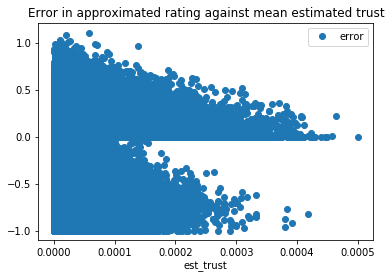

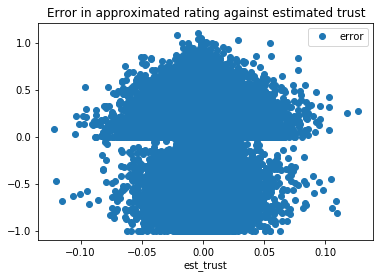

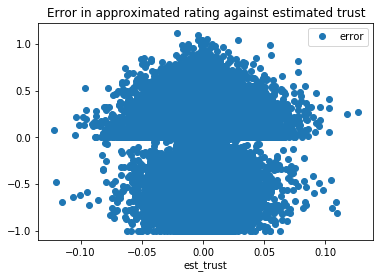

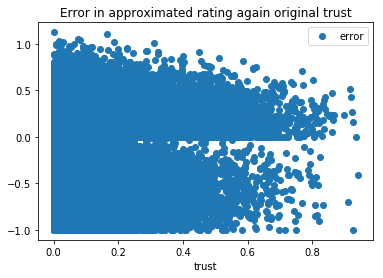

In [3]:
import pandas as pd
import numpy as np
import plotly.plotly as py
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import SVDpp
from surprise import SVDppimp
from impt import ImpliciTrust
from surprise import accuracy
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


# dataset_name ='ml-100k'
# dataset_name ='ml-1m'
# dataset_name ='ml-20m'
# dataset_name ='ml-latest-small'
print(dataset_name)
algos = {'STACK_MEANTRUST_COL': 5, 'ADD_TRUST': 3, 'WEIGHT_BY_TRUST': 2}

for algoname, compare in algos.items():
    data = Dataset.load_builtin(dataset_name, binary=True, pos_ne_divider=2.5)
    trainset, testset = train_test_split(data,random_state=100, test_size=.2)
    algo = SVD(n_factors= 20, random_state=100, biased=False)
    final_algo = SVDpp(n_factors= 20, random_state=100)
    myalgo = ImpliciTrust(algo, final_algo, compare=compare, random_state=100)
    myalgo.fit(trainset)
    print(algoname)
    predictions = myalgo.test(testset)
    accuracy.mae(predictions)
    
    
    def get_Iu(uid):
        try:
            return myalgo.trainset.to_inner_uid(uid)
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(iid):
        try:
            return myalgo.trainset.to_inner_iid(iid)
        except ValueError:  # item was not part of the trainset
            return 0
    
    df = pd.DataFrame(predictions, columns=['user_id', 'item_id', 'ratings_ui', 'estimated_Ratings', 'details'])
    df['Ii'] = df.user_id.apply(get_Iu)
    df['Ui'] = df.item_id.apply(get_Ui)
    df['error'] = df.ratings_ui - df.estimated_Ratings
    t = []
    est_t = []
    for index, row in df.iterrows():
        val = myalgo.single_user_trust(row['user_id'], row['item_id'])
        esttr = myalgo.single_user_item_est_trust(row['user_id'], row['item_id'])
        t.append(val)
        est_t.append(esttr)
    df['trust'] = t
    df['est_trust'] = est_t
    if algoname == 'STACK_MEANTRUST_COL':
        title='Error in approximated rating against mean estimated trust'
        xlable = 'Mean estimated trust'
        
    else:
        title='Error in approximated rating against estimated trust'
        xlable='Estimated trust'
    dplt = df.plot(x='est_trust', y='error',style=['o'], title=title)
    fig = dplt.get_figure()
    fig.savefig(algoname+dataset_name+'.png', format='png', dpi=1000)
    fig.show()
    
    
algos = {'SVD':SVD(n_factors= 20, random_state=100), 'SVDpp': SVDpp(n_factors= 20, random_state=100), 'SVDppimp': SVDppimp(n_factors= 20, random_state=100)}
for algoname, algo in algos.items():
    data = Dataset.load_builtin(dataset_name, binary=True, pos_ne_divider=2.5)
    trainset, testset = train_test_split(data,random_state=100, test_size=.2)
    algo.fit(trainset)
    print(algoname)
    predictions = algo.test(testset)
    accuracy.mae(predictions)
    if algoname == 'SVDppimp':
        df = pd.DataFrame(predictions, columns=['user_id', 'item_id', 'ratings_ui', 'estimated_Ratings', 'details'])
        def get_Iu(uid):
            try:
                return myalgo.trainset.to_inner_uid(uid)
            except ValueError:  # user was not part of the trainset
                return 0

        def get_Ui(iid):
            try:
                return myalgo.trainset.to_inner_iid(iid)
            except ValueError:  # item was not part of the trainset
                return 0
    
        df = pd.DataFrame(predictions, columns=['user_id', 'item_id', 'ratings_ui', 'estimated_Ratings', 'details'])
        df['Ii'] = df.user_id.apply(get_Iu)
        df['Ui'] = df.item_id.apply(get_Ui)
        df['error'] = df.ratings_ui - df.estimated_Ratings
        df['trust'] = (df.Ui/myalgo.trainset.n_users) * (df.Ii/myalgo.trainset.n_items)
        dplt = df.plot(x='trust', y='error',style=['o'], title='Error in approximated rating again original trust')
        fig = dplt.get_figure()
        fig.savefig(algoname+dataset_name+'.png', format='png', dpi=1000)
        fig.show()